# Libraries

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(6,4))

In [3]:
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

# Gathering Data and Storing

In [87]:
data = yf.download('AAPL', period='10y')
data.to_csv('Apple_Data.csv')

[*********************100%***********************]  1 of 1 completed


In [88]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-02,225.889999,227.369995,223.020004,226.779999,226.779999,32880600
2024-10-03,225.139999,226.809998,223.320007,225.669998,225.669998,34044200
2024-10-04,227.899994,228.000000,224.130005,226.800003,226.800003,37245100
2024-10-07,224.500000,225.690002,221.330002,221.690002,221.690002,39168300
2024-10-08,224.309998,225.960007,223.250000,224.820007,224.820007,15039940


# Reading Data and Working

In [89]:
df_raw=pd.read_csv('Apple_Data.csv')

In [90]:
df_raw.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-08,24.690001,25.277500,24.577499,25.200001,22.375263,229618800
1,2014-10-09,25.385000,25.594999,25.152500,25.254999,22.424097,309506000
2,2014-10-10,25.172501,25.507500,25.075001,25.182501,22.359724,265326400
3,2014-10-13,25.332500,25.445000,24.952499,24.952499,22.155504,214333600
4,2014-10-14,25.097500,25.129999,24.642500,24.687500,21.920214,254754400
5,2014-10-15,24.492500,24.787500,23.795000,24.385000,21.651623,403734400
6,2014-10-16,23.887501,24.430000,23.852501,24.065001,21.367489,288618000
7,2014-10-17,24.375000,24.750000,24.202499,24.417500,21.680471,272718800
8,2014-10-20,24.580000,24.990000,24.555000,24.940001,22.144403,310069200
9,2014-10-21,25.754999,25.754999,25.317499,25.617500,22.745966,378495600


In [91]:
df=df_raw.reset_index()['Close']

In [92]:
df.shape

(2517,)

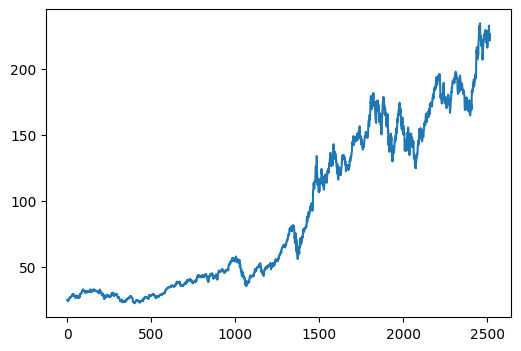

In [93]:
plt.plot(df)

In [94]:
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [95]:
df.shape

(2517, 1)

In [96]:
train_size=int(len(df)*0.8)
test_size=len(df)-train_size
train_df,test_df=df[0:train_size, :], df[train_size: len(df),:1]

print(train_size,test_size )

2013 504


# Creating Datasets

In [97]:
def create_datasets(dataset, time_step=1):
    datax, datay=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        datax.append(a)
        datay.append(dataset[i+time_step,0])
    return np.array(datax), np.array(datay)


In [98]:
time_step=100
train_df, train_target=create_datasets(train_df, time_step)
test_df, test_target=create_datasets(test_df, time_step)

In [99]:
(train_df.shape, train_target.shape), (test_df.shape, test_target.shape)

(((1912, 100), (1912,)), ((403, 100), (403,)))

In [100]:
train_df=train_df.reshape(train_df.shape[0], train_df.shape[1], 1)
test_df=test_df.reshape(test_df.shape[0], test_df.shape[1], 1)

print((train_df.shape, train_target.shape), (test_df.shape, test_target.shape))

((1912, 100, 1), (1912,)) ((403, 100, 1), (403,))


# Model

In [106]:
model=Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(100,1)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

model.add(LSTM(35, activation='relu', return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(LSTM(25,activation='relu', return_sequences=True))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.3))

model.add(LSTM(10, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(Dense(1))
     
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['accuracy']
              )

In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_15 (LSTM)              (None, 100, 35)           12040     
                                                                 
 lstm_16 (LSTM)              (None, 100, 25)           6100      
                                                                 
 lstm_17 (LSTM)              (None, 10)                1440      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 29,991
Trainable params: 29,991
Non-trainable params: 0
_________________________________________________________________


In [108]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

history = model.fit(train_df, train_target,
                        epochs=100,batch_size=64,verbose=1,
                        validation_data=(test_df, test_target),
                        # callbacks=[early_stop, 
                        #            reduce_lr]
                                )

Epoch 1/100
30/30 [==============================] - 14s 257ms/step - loss: 0.0223 - accuracy: 5.2301e-04 - val_loss: 0.0040 - val_accuracy: 0.0025
Epoch 2/100
30/30 [==============================] - 7s 227ms/step - loss: 7.1236e-04 - accuracy: 5.2301e-04 - val_loss: 0.0085 - val_accuracy: 0.0025
Epoch 3/100
30/30 [==============================] - 7s 222ms/step - loss: 5.9043e-04 - accuracy: 5.2301e-04 - val_loss: 0.0030 - val_accuracy: 0.0025
Epoch 4/100
30/30 [==============================] - 7s 218ms/step - loss: 5.8451e-04 - accuracy: 5.2301e-04 - val_loss: 0.0023 - val_accuracy: 0.0025
Epoch 5/100
30/30 [==============================] - 7s 222ms/step - loss: 6.1168e-04 - accuracy: 5.2301e-04 - val_loss: 0.0070 - val_accuracy: 0.0025
Epoch 6/100
30/30 [==============================] - 7s 235ms/step - loss: 5.4353e-04 - accuracy: 5.2301e-04 - val_loss: 0.0050 - val_accuracy: 0.0025
Epoch 7/100
30/30 [==============================] - 7s 245ms/step - loss: 5.8486e-04 - accuracy:

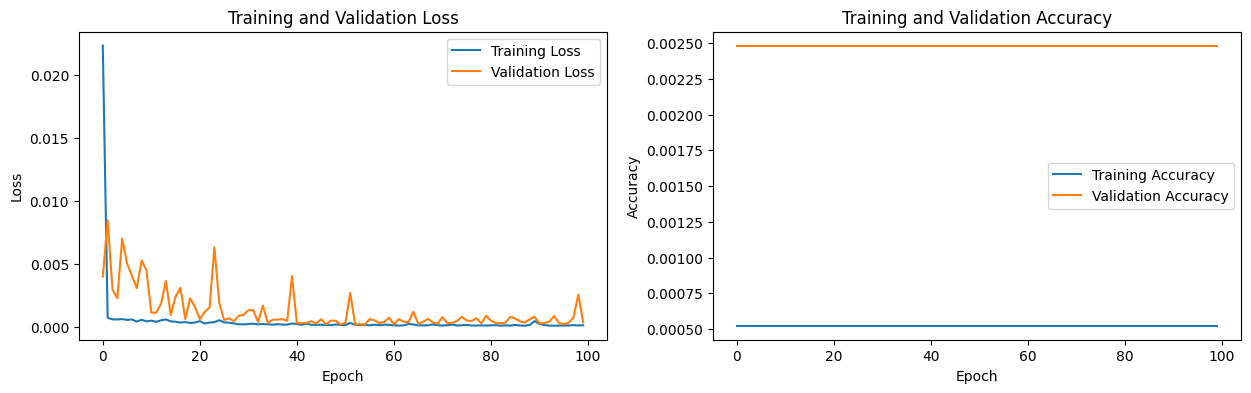

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()


ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

In [110]:
train_predict= model.predict(train_df)

test_predict= model.predict(test_df)

13/13 [==============================] - 1s 55ms/step


In [111]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_target,train_predict))

0.010217880722340138

In [112]:
train_predict= scaler.inverse_transform(train_predict)

test_predict= scaler.inverse_transform(test_predict)

In [113]:
train_predict

array([[ 33.384117],
       [ 33.20856 ],
       [ 33.01729 ],
       ...,
       [143.3212  ],
       [140.03249 ],
       [144.61612 ]], dtype=float32)

In [114]:
print('Training:', root_mean_squared_error(train_target, train_predict))

print('Testing:',root_mean_squared_error(test_target, test_predict))

Training: 87.05881484579815
Testing: 186.99076082856035


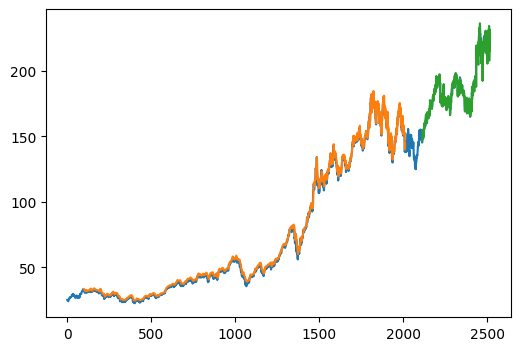

In [115]:
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1 : len(train_predict)+(look_back*2)+1 + len(test_predict), :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [116]:
len(test_df)

403

In [132]:
x_input=test_df[402:].reshape(1,-1)
x_input.shape

(1, 100)

In [133]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [134]:
temp_input

[0.7767097189031862,
 0.7874996850068698,
 0.788065072961396,
 0.7882064199500274,
 0.7937191681938216,
 0.7998916315788582,
 0.7930595249483008,
 0.7741183095144606,
 0.7887247162069169,
 0.7887718798002752,
 0.7901853496865905,
 0.7948971076962321,
 0.7994204270196057,
 0.8078073505251102,
 0.8093151475981417,
 0.8164769680078778,
 0.8099276272503044,
 0.8212829813085143,
 0.803519633481363,
 0.8696255926049787,
 0.8975192632902926,
 0.9030320115340871,
 0.8947864350172141,
 0.91448154898757,
 0.9032675419179916,
 0.8815463346177144,
 0.8712276449690053,
 0.8742902589169836,
 0.8786722312517257,
 0.8983673452220817,
 0.9023723682885658,
 0.8859753986500931,
 0.9148584982558279,
 0.9314439065805686,
 0.9374749510812523,
 0.9600442403133189,
 0.9670176939325081,
 0.9710697368009071,
 0.9913303106215108,
 0.9658397544300976,
 0.9798336095746696,
 0.9980209983677157,
 1.0,
 0.9720121459194129,
 0.9498668257575196,
 0.9504793773054037,
 0.9488303051394622,
 0.9537775935330088,
 0.92329251

In [135]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9604643]
101
1 day input [0.78749969 0.78806507 0.78820642 0.79371917 0.79989163 0.79305952
 0.77411831 0.78872472 0.78877188 0.79018535 0.79489711 0.79942043
 0.80780735 0.80931515 0.81647697 0.80992763 0.82128298 0.80351963
 0.86962559 0.89751926 0.90303201 0.89478644 0.91448155 0.90326754
 0.88154633 0.87122764 0.87429026 0.87867223 0.89836735 0.90237237
 0.8859754  0.9148585  0.93144391 0.93747495 0.96004424 0.96701769
 0.97106974 0.99133031 0.96583975 0.97983361 0.998021   1.
 0.97201215 0.94986683 0.95047938 0.94883031 0.95377759 0.92329251
 0.91834523 0.92055976 0.92187904 0.92451762 0.93997218 0.92244443
 0.92951207 0.87961457 0.87000254 0.88220605 0.89865004 0.91245553
 0.91853366 0.93615566 0.93827594 0.95241122 0.95867786 0.95792396
 0.96084523 0.96032693 0.95151597 0.96240012 0.9640021  0.96800712
 0.96075105 0.97629979 0.97257753 0.9432233  0.93417673 0.94138572
 0.93403539 0.93445943 0.93069001 0.94270501 0.9432233  0.94195111
 0.91283248 0.91504694 0.93342284 0.971964

In [136]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [137]:
len(df)

2517

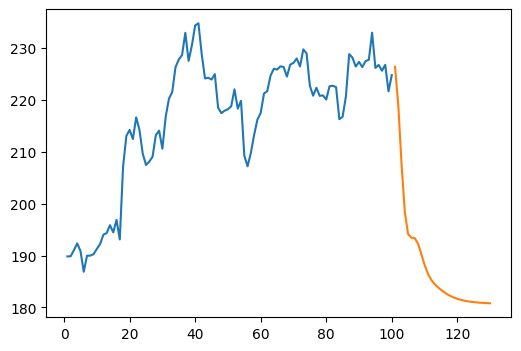

In [140]:
plt.plot(day_new,scaler.inverse_transform(df[len(df)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

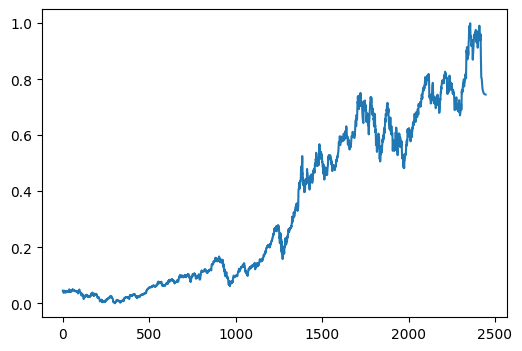

In [144]:
df_new=df.tolist()
df_new.extend(lst_output)
plt.plot(df_new[100:])